# To do:
- Machine Learning: investigate Facebook's Prophet library 
- Learn more about time series analysis

In [1]:
### Imports ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from datetime import timedelta
import calendar # for getting month name i.e. Feb from month number
from urllib.request import urlretrieve # for getting data from URLs
from datetime import datetime
import datetime as dt
import os # for deleting files
import statsmodels.api as sm # for time series decomposition
%matplotlib inline

In [2]:
### Get data ###
def get_data(location_input):
    '''Returns data for desired location.
    
    Keyword arguments:
    location -- string of location wanted.
    '''
    # Dictionary of URLs from different locations
    Derby = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2017.csv'
    }
    Reading = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/REA5_2017.csv'
    }
    Nottingham_Centre = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2018.csv',
        '2017' : 'https://uk-air.defra.gov.uk/data_files/site_data/NOTT_2017.csv'
    }
    Burton_On_Trent_Centre = {
        '2020' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2020.csv',
        '2019' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2019.csv',
        '2018' : 'https://uk-air.defra.gov.uk/data_files/site_data/BOTR_2018.csv'  
    } # no 2017 data for Burton
    
    # Turning above dictionaries into one dictionary
    data_locations = {
      "Derby" : Derby,
      "Reading" : Reading,
      "Nottingham_Centre" : Nottingham_Centre,
      "Burton_Centre" : Burton_On_Trent_Centre
    }

    global df_2020, df_2019, df_2018, df_2017,location_string # so that these can be used outside of function
    location_string = location_input # for plot titles
    
    # Getting URLs for requested location
    URL_2020 = data_locations[location_input]['2020']
    URL_2019 = data_locations[location_input]['2019']
    URL_2018 = data_locations[location_input]['2018']
    URL_2017 = data_locations[location_input]['2017']
   
    # Making dataframes
    df_2020 = pd.read_csv(URL_2020,skiprows=4)
    df_2019 = pd.read_csv(URL_2019,skiprows=4)
    df_2018 = pd.read_csv(URL_2018,skiprows=4)
    df_2017 = pd.read_csv(URL_2017,skiprows=4)
    
    print('Successfully got data for {}!'.format(location_input))

In [3]:
get_data('Derby')

Successfully got data for Derby!


In [4]:
df_2020.tail(2)

,Date,time,Nitric oxide,status,unit,Nitrogen dioxide,status.1,unit.1,Nitrogen oxides as nitrogen dioxide,status.2,unit.2
2422,10-04-2020,23:00,0.49892,P,ugm-3,27.54000,P,ugm-3,28.30500,P,ugm-3
2423,10-04-2020,24:00,1.24730,P,ugm-3,38.05875,P,ugm-3,39.97125,P,ugm-3


In [5]:
### Cleaning data ###
def datetime_cleaner(variable):
    '''Take every date + time where date is i.e. 1/1/2020 24:00 and turn it into 2/1/2020 00:00. 
    Also removes redundant columns
    
    Keyword arguments:
    variable -- the dataframe inputted i.e. df_2020
    '''
    # Changing date from object to datetime
    variable['Date'] = pd.to_datetime(variable['Date']).dt.strftime('%d-%m-%Y') # makes sure string is in correct format
    variable['Date'] = pd.to_datetime(variable['Date']) # converts to datetime
    
    # Loop to add 1 for every 24th entry, as they are stored as date x & 24:00 when they need to be date x + 1 & 00:00
    counter = 0
    for i, row in variable.iterrows():
        counter += 1
        if counter % 24 == 0:
            value = variable.at[i,'Date'] + pd.Timedelta(1,unit='d')
            variable.at[i,'Date'] = value
    
    # Replacing 24:00 with 00:00
    variable['time'] = variable['time'].replace(to_replace='24:00',value='00:00') 
    
    # Combining date and time columns
    variable['Date String'] = variable['Date'].astype(str)
    variable['Date Time String'] = variable['Date String'] + " " + variable['time']
    variable['Date Time'] = pd.to_datetime(variable['Date Time String'])
    
    # Feature Engineering
    variable['Week'] = variable['Date Time'].dt.week
    variable['Day Of Week'] = variable['Date Time'].dt.dayofweek
    variable['Quarter'] = variable['Date Time'].dt.quarter
    variable['Month'] = variable['Date Time'].dt.month
    variable['Weekday Or Weekend'] = np.where(variable['Day Of Week'] >=5,'Weekend','Weekday')
    variable['Total'] = variable['Nitric oxide'] + variable['Nitrogen dioxide']
    
    # Setting index to be Date Time
    variable.index = variable['Date Time']
    
    # Removing columns
    variable.drop(['Date','time','Date String','Date Time String'],axis=1,inplace=True)
    variable.drop(['status','unit','status.1','unit.1','status.2','unit.2'],axis=1,inplace=True)
          
    # Removing columns that only exists in some locations (i.e. Reading has 'unit.3') whereas Derby doesn't
    variable.drop(['status.3','unit.3'],axis=1,inplace=True,errors='ignore') 

In [6]:
datetime_cleaner(df_2020)
datetime_cleaner(df_2019)
datetime_cleaner(df_2018)
datetime_cleaner(df_2017)

# Make new dataframe containing all data
frames = [df_2017,df_2018,df_2019,df_2020]
df_all = pd.concat(frames)
df_all.index = df_all['Date Time']

In [7]:
df_2020.tail(2)

,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,Date Time,Week,Day Of Week,Quarter,Month,Weekday Or Weekend,Total
Date Time,,,,,,,,,,
2020-04-10 23:00:00,0.49892,27.54000,28.30500,2020-04-10 23:00:00,15,4,2,4,Weekday,28.03892
2020-04-11 00:00:00,1.24730,38.05875,39.97125,2020-04-11 00:00:00,15,5,2,4,Weekend,39.30605


# Exploratory data analysis

In [13]:
# function to let you decide date range to plot, resample type, line or bar, and aggregate type
def plot_date_range(start,end,resample_string,plottype,aggregate):
    '''
    Keyword arguments:
    start -- date string in format YYYY-MM-DD
    end -- date string in format YYYY-MM-DD
    resample_string -- string of 'H'/'D'/'W'/'M'
    plottype -- string 'line' or 'bar'
    aggregate -- string 'sum','average','median'
    '''
    # Capitalise user input (in case user were to input 'h' instead of 'H')
    resample_string = resample_string.upper()
    
    # For chart title 
    if resample_string == 'H':
        title_string = 'Hourly'
    elif resample_string == 'D':
        title_string = 'Daily'
    elif resample_string == 'W':
        title_string = 'Weekly'
    elif resample_string == 'M':
        title_string = 'Monthly'
    
    # Dates to plot. Convert inputted string to datetime object with strptime
    start = datetime.strptime(start,'%Y-%m-%d')
    end = datetime.strptime(end,'%Y-%m-%d')
    
    # Plot styling
    plt.style.use('seaborn-poster')
    
    # Resampling data based on user input
    if resample_string == 'H':
        df_all_ = df_all.loc[start:end]
        if plottype == 'line':
            fig = df_all_[['Total','Nitric oxide','Nitrogen dioxide']].plot(figsize=(15,10))
        elif plottype == 'bar':
            fig = df_all_[['Total','Nitric oxide','Nitrogen dioxide']].plot.bar(figsize=(15,10))
        fig.set_title('Hourly Emissions Between {} and {}'.format(start,end))
        fig.set_ylim(0)
    else:    
        df_all_ = df_all.loc[start:end]
        if plottype == 'line':
            if aggregate == 'sum':
                fig = df_all_[['Total','Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot(figsize=(15,10))
            elif aggregate == 'mean':
                fig = df_all_[['Total','Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot(figsize=(15,10))
            elif aggregate == 'median': 
                fig = df_all_[['Total','Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot(figsize=(15,10))
            fig.set_title('{} {} Emissions Between {} and {} for {}'.format(aggregate.title(),title_string,start,end,location_string))
            fig.set_ylim(0)
        elif plottype == 'bar':
            if aggregate == 'sum':
                fig = df_all_[['Total','Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot.bar(figsize=(15,10))
            elif aggregate == 'mean':
                fig = df_all_[['Total','Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot.bar(figsize=(15,10))
            elif aggregate == 'median':
                fig = df_all_[['Total','Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot.bar(figsize=(15,10))
            fig.set_title('{} {} Emissions Between {} and {} for {}'.
                          format(aggregate.title(),title_string,start,end,location_string))
            fig.set_ylim(0)
    
    # Stylings
    fig.set_ylim(0,None)
    fig.set_facecolor('#eaeaf2')
    fig.grid(True,color='w')
    plt.ylabel('Total Emissions Measured (ugm$^3$)')
    plt.legend(loc='upper center')

In [34]:
# function to let you decide date range to plot, resample type, line or bar, and aggregate type
def plot_date_range(start,end,resample_string,plottype,aggregate,cols):
    '''
    Keyword arguments:
    start -- date string in format YYYY-MM-DD
    end -- date string in format YYYY-MM-DD
    resample_string -- string of 'H'/'D'/'W'/'M'
    plottype -- string 'line' or 'bar'
    aggregate -- string 'sum','average','median'
    cols -- if 1, plot total. If 2, plot NO and NO2. If 3, plot total & NO & NO2. If 4, just NO. If 5, just NO2.
    '''
    # Capitalise user input (in case user were to input 'h' instead of 'H')
    resample_string = resample_string.upper()
    
    # For chart title 
    if resample_string == 'H':
        title_string = 'Hourly'
    elif resample_string == 'D':
        title_string = 'Daily'
    elif resample_string == 'W':
        title_string = 'Weekly'
    elif resample_string == 'M':
        title_string = 'Monthly'
        
    # Data to plot (from 'cols' parameter)
    if cols == 1:
        data_to_plot = ['Total']
    elif cols == 2:
        data_to_plot = ['Nitric oxide', 'Nitrogen dioxide']
    elif cols == 3:
        data_to_plot = ['Total', 'Nitric oxide', 'Nitrogen dioxide']
    elif cols == 4:
        data_to_plot = ['Nitric oxide']
    elif cols == 5:
        data_to_plot = ['Nitrogen dioxide']
    
    # Dates to plot. Convert inputted string to datetime object with strptime
    start = datetime.strptime(start,'%Y-%m-%d')
    end = datetime.strptime(end,'%Y-%m-%d')
    
    # Plot styling
    plt.style.use('seaborn-poster')
    
    # Resampling data based on user input
    if resample_string == 'H':
        df_all_ = df_all.loc[start:end]
        if plottype == 'line':
            fig = df_all_[data_to_plot].plot(figsize=(15,10))
        elif plottype == 'bar':
            fig = df_all_[data_to_plot].plot.bar(figsize=(15,10))
        fig.set_title('Hourly Emissions Between {} and {}'.format(start,end))
        fig.set_ylim(0)
    else:    
        df_all_ = df_all.loc[start:end]
        if plottype == 'line':
            if aggregate == 'sum':
                fig = df_all_[data_to_plot].resample(resample_string).sum().plot(figsize=(15,10))
            elif aggregate == 'mean':
                fig = df_all_[data_to_plot].resample(resample_string).mean().plot(figsize=(15,10))
            elif aggregate == 'median': 
                fig = df_all_[data_to_plot].resample(resample_string).median().plot(figsize=(15,10))
            fig.set_title('{} {} Emissions Between {} and {} for {}'.format(aggregate.title(),title_string,start,end,location_string))
            fig.set_ylim(0)
        elif plottype == 'bar':
            if aggregate == 'sum':
                fig = df_all_[data_to_plot].resample(resample_string).sum().plot.bar(figsize=(15,10))
            elif aggregate == 'mean':
                fig = df_all_[data_to_plot].resample(resample_string).mean().plot.bar(figsize=(15,10))
            elif aggregate == 'median':
                fig = df_all_[data_to_plot].resample(resample_string).median().plot.bar(figsize=(15,10))
            fig.set_title('{} {} Emissions Between {} and {} for {}'.
                          format(aggregate.title(),title_string,start,end,location_string))
            fig.set_ylim(0)
    
    # Stylings
    fig.set_ylim(0,None)
    fig.set_facecolor('#eaeaf2')
    fig.grid(True,color='w',axis='y')
    plt.ylabel('Total Emissions Measured (ugm$^3$)')
    plt.legend(loc='upper center')
    plt.xlabel('')

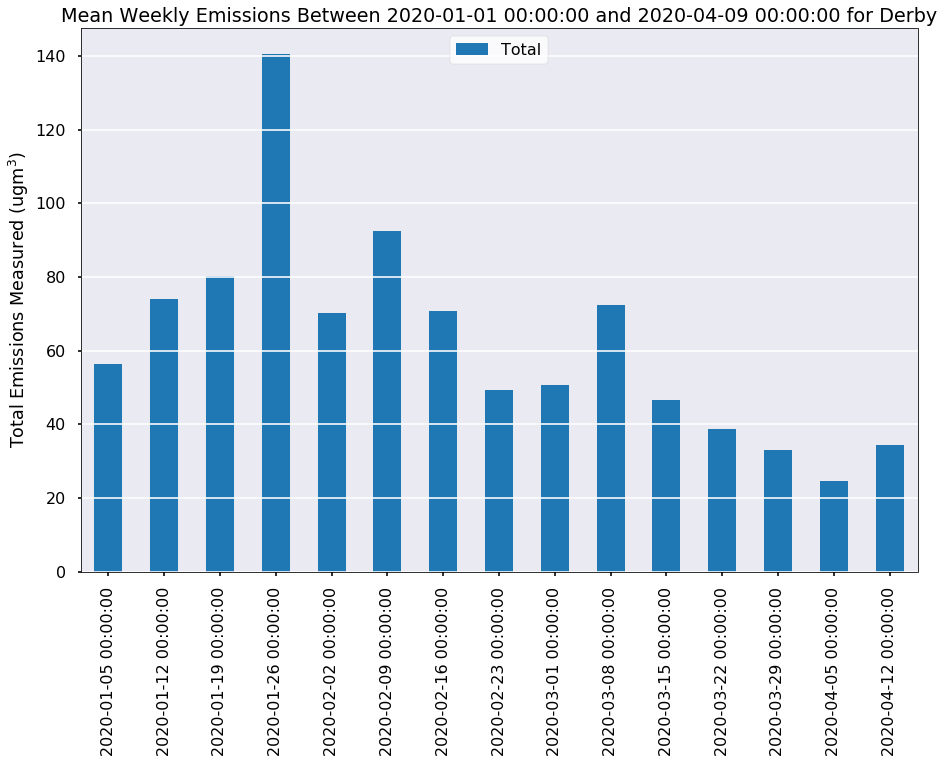

In [37]:
plot_date_range(start='2020-01-01',end='2020-04-09',resample_string='W',plottype='bar',aggregate='mean',cols=1)

# Rolling summary

Text(0.5, 1.0, '365 Day Rolling Average Of Pollution From Derby Sensor')

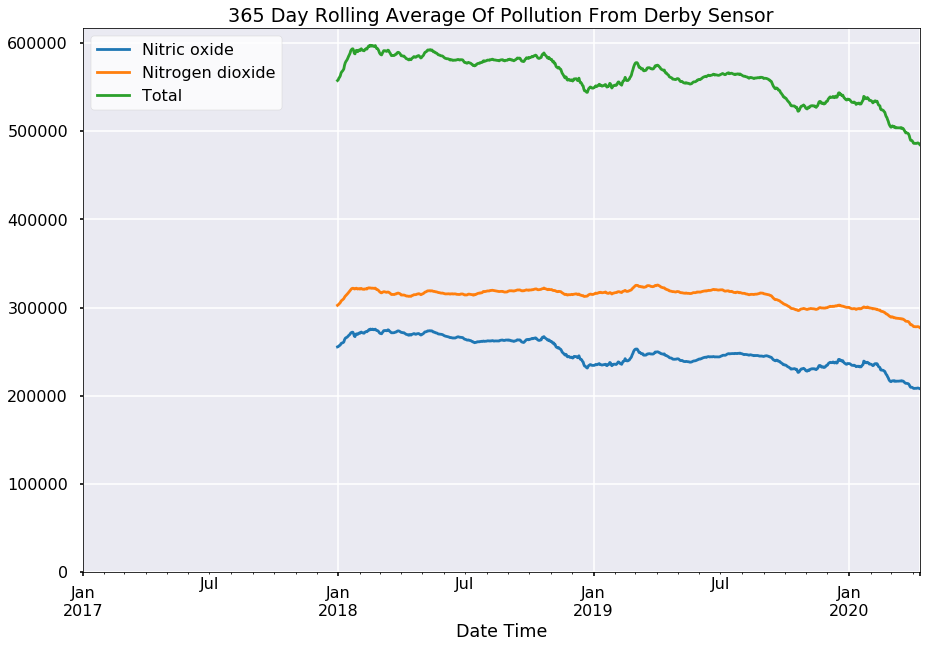

In [112]:
# Matplotlib plot
plt.style.use('seaborn-poster') # making the font bigger so it can be read on Instagram

# Make fig
fig = df_all[['Nitric oxide','Nitrogen dioxide',
             'Total']].resample('D').sum().rolling(365).sum().plot(figsize=[15,10])

# Stylings
fig.set_ylim(0,None)
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('365 Day Rolling Average Of Pollution From {} Sensor'.format(location_string))

#sns.axes_style({'axes.facecolour':'grey', 'axes.grid':True})

Text(0.5, 1.0, '365 Day Rolling Average Of Pollution From Derby Sensor, ZOOMED IN')

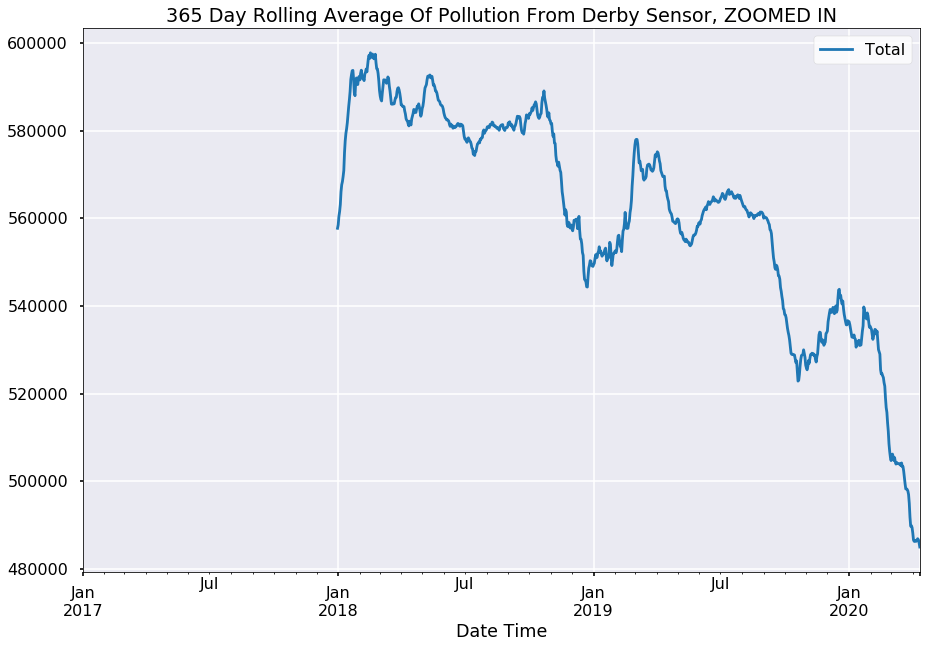

In [113]:
plt.style.use('seaborn-poster')
fig = df_all[['Total']].resample('D').sum().rolling(365).sum().plot(figsize=[15,10])

# Stylings
fig.set_ylim(None,None) # sets limits to be min and max of the data
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('365 Day Rolling Average Of Pollution From {} Sensor, ZOOMED IN'.format(location_string))

## Groupby to assess pollution per hour

Text(0.5, 1.0, 'Average pollution per hour since records began from Derby sensor')

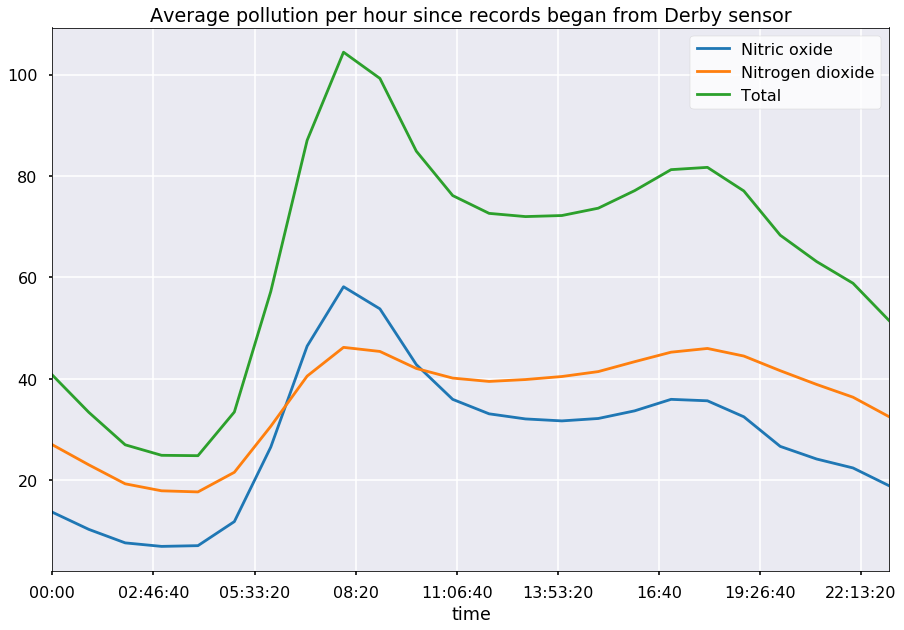

In [121]:
plt.style.use('seaborn-poster')


fig = df_all[['Nitric oxide','Nitrogen dioxide','Total']].groupby(df_all[['Nitric oxide','Nitrogen dioxide',
             'Total']].index.time).mean().plot(figsize=[15,10])

# Stylings
fig.set_ylim(None,None) # sets limits to be min and max of the data
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('Average pollution per hour since records began from {} sensor'.format(location_string))

Text(0.5, 1.0, 'Average pollution per hour in 2020 from Derby sensor')

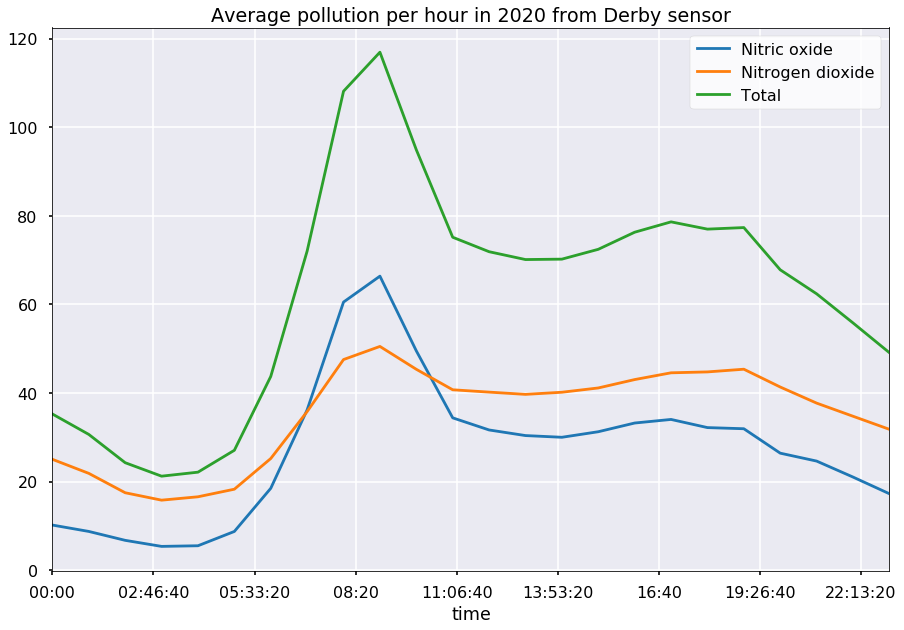

In [122]:
plt.style.use('seaborn-poster')

fig = df_2020[['Nitric oxide','Nitrogen dioxide','Total']
      ].groupby(df_2020[['Nitric oxide','Nitrogen dioxide',
             'Total']].index.time).mean().plot(figsize=[15,10])
plt.title('Average pollution per hour in 2020')

# Stylings
fig.set_ylim(None,None) # sets limits to be min and max of the data
fig.set_facecolor('#eaeaf2')
fig.grid(True,color='w')
plt.title('Average pollution per hour in 2020 from {} sensor'.format(location_string))

In [123]:
# mental thing plotting all days hourly pollution
#pivoted = df_all.pivot_table('Total',index=df_all.index.time,columns=df_all.index.date)
#pivoted.plot(legend=False,alpha=0.2,figsize=[15,10])

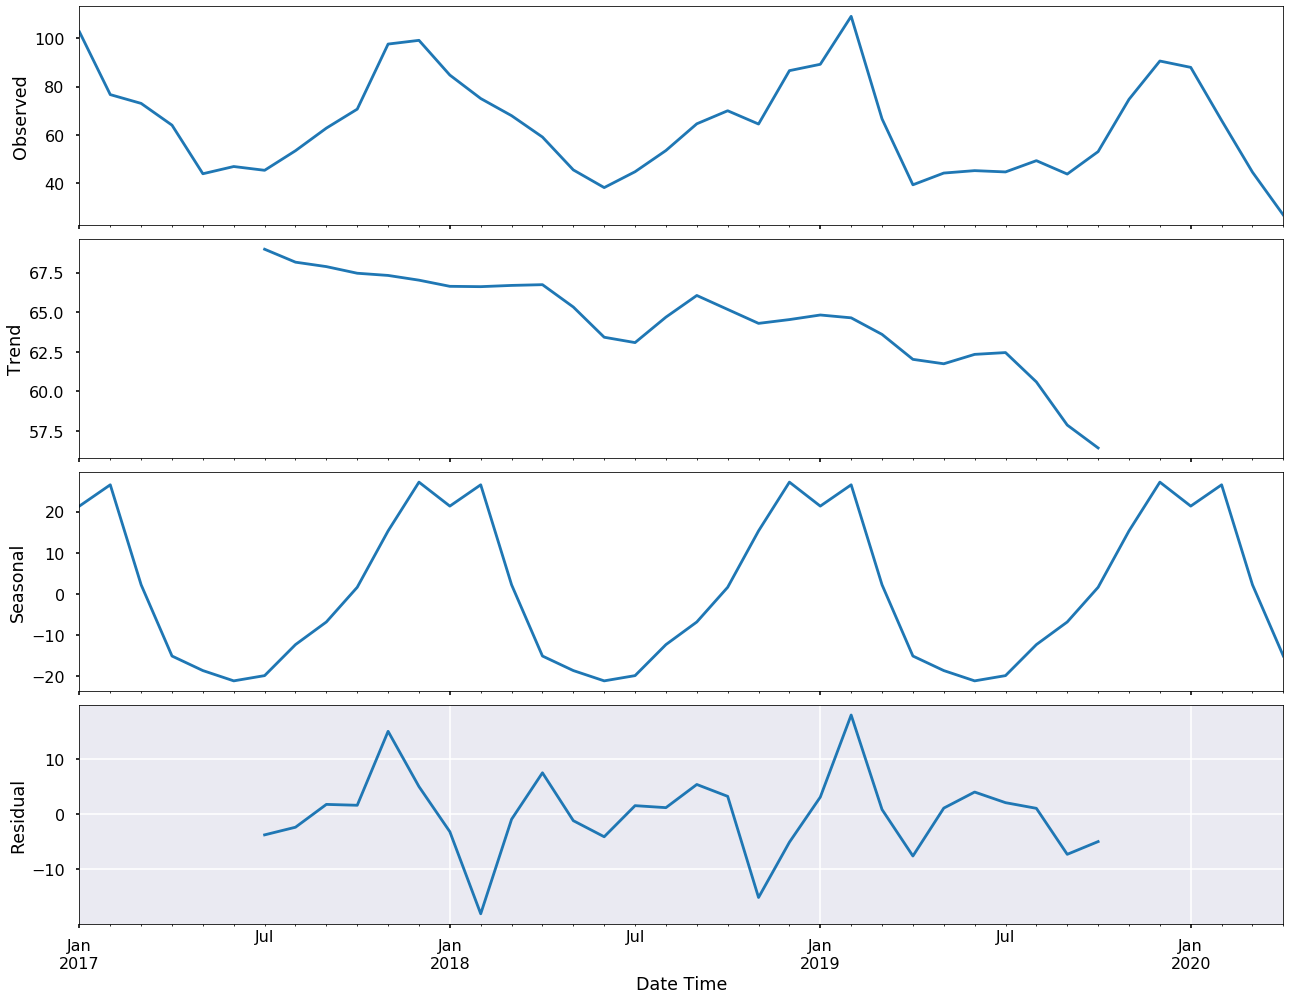

In [39]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 14
y = df_all['Total'].resample('M').mean()
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()

# Stylings
ax = fig.gca() # not entirely sure what this does but it lets me make an ax after the fact for editing!
ax.set_facecolor('#eaeaf2')
plt.grid(True,color='w')

# Comparing multiple years on one plot

In [42]:
# Compare years on the same plot, by either hourly or daily data
# Should try and rebuild this function as I've made it in a very clunky way, but hey it works!
# To do - replace masks with .loc
def year_comparison(start,end,resample_string,years_of_data):
    '''Compare years on the same plot, by either hourly or daily data
    
    Keyword arguments:
    start = string of date in format 'MM-DD'
    end = string of date in format 'MM-DD'
    resample_string = 'H','D'
    years_of_data = 1, 2, 3 or 4, determines how many years to plot
    '''
    global df_2020, df_2019, df_2018, df_2017
    
    # Turn inputted start and date "MM-DD" to the 4 years "YYYY-MM-DD" for use to get necessary data
    start_2020 = '2020-' + start
    start_2020 = pd.to_datetime(start_2020)
    end_2020 = '2020-' + end
    end_2020 = pd.to_datetime(end_2020)
    
    start_2019 = '2019-' + start
    start_2019 = pd.to_datetime(start_2019)
    end_2019 = '2019-' + end
    end_2019 = pd.to_datetime(end_2019)
       
    start_2018 = '2018-' + start
    start_2018 = pd.to_datetime(start_2018)
    end_2018 = '2018-' + end
    end_2018 = pd.to_datetime(end_2018)
    
    start_2017 = '2017-' + start
    start_2017 = pd.to_datetime(start_2017)
    end_2017 = '2017-' + end
    end_2017 = pd.to_datetime(end_2017)
    
    # Returning new dataframes df_2020_ etc for each year between the requested dates ###
    df_2020_ = df_2020.loc[start_2020:end_2020]
    df_2019_ = df_2019.loc[start_2019:end_2019]
    df_2018_ = df_2018.loc[start_2018:end_2018]
    df_2017_ = df_2017.loc[start_2017:end_2017]
    
    ### HOURLY PLOT ###
    if resample_string=='H':
        ### Making date time no year column
        df_2020_['Date Time No Year'] = df_2020_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2019_['Date Time No Year'] = df_2019_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2018_['Date Time No Year'] = df_2018_['Date Time'].dt.strftime('%m-%d %H:%M')
        df_2017_['Date Time No Year'] = df_2017_['Date Time'].dt.strftime('%m-%d %H:%M')

        ### Plotting them with date time no year
        plt.figure(figsize=(15,10))
        
        if years_of_data==4:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                        label = '2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Total'],
                        label = '2019 Total Pollution',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Total'],
                        label = '2018 Total Pollution',alpha=0.6,linestyle=':',color='#FF9914')
            sns.lineplot(x=df_2017_['Date Time No Year'],y=df_2017_['Total'],
                        label ='2017 Total Pollution',alpha=0.6,linestyle='-.',color='#EC4E20')
        
        elif years_of_data==3:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                    label = '2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Total'],
                        label = '2019 Total Pollution',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Total'],
                        label = '2018 Total Pollution',alpha=0.6,linestyle=':',color='#FF9914')
    
        elif years_of_data==2:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                    label = '2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Nitric oxide'],
                        label = '2019 Total Pollution',linestyle=':',alpha=0.6,color='#775253')
            
        elif years_of_data==1:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                    label = '2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
    
        # Stylings
        plt.xticks(rotation=90) # would be great to strip the hours from the x ticks
        plt.xlabel('')
        plt.ylabel('Total Pollution NO + NO\N{SUBSCRIPT TWO} (ugm$^3$))')
        plt.title('Hourly Total Pollution (NO + NO\N{SUBSCRIPT TWO}) Emissions From Date {} to {} of Each Year'.format(start,end))
        plt.legend(loc='upper center')
        plt.xticks('')
        ax = plt.gca() # not entirely sure what this does but it lets me make an ax after the fact for editing!
        ax.set_facecolor('#eaeaf2')
        plt.grid(True,color='w')
    
    ### DAILY PLOT ###
    elif resample_string!='H':
        ### Resample accordingly (however only by day works)
        plt.figure(figsize=(15,10))
        df_2020_ = df_2020_.resample(resample_string).sum()
        df_2019_ = df_2019_.resample(resample_string).sum()
        df_2018_ = df_2018_.resample(resample_string).sum()
        df_2017_ = df_2017_.resample(resample_string).sum()
                
        ### Making date time no year column
        df_2020_['Date Time No Year'] = df_2020_.index.strftime('%m-%d %H:%M')
        df_2019_['Date Time No Year'] = df_2019_.index.strftime('%m-%d %H:%M')
        df_2018_['Date Time No Year'] = df_2018_.index.strftime('%m-%d %H:%M')
        df_2017_['Date Time No Year'] = df_2017_.index.strftime('%m-%d %H:%M')
        
        #### Replacing date time as index as removing datatime column 
        def cleaner(variable):
            variable.index = variable['Date Time No Year']

        cleaner(df_2020_)
        cleaner(df_2019_)
        cleaner(df_2018_)
        cleaner(df_2017_)

        plt.figure(figsize=(15,10))
        if years_of_data==4:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                         label='2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Total'],
                         label='2019 Total Pollution',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Total'],
                         label='2018 Total Pollution',alpha=0.6,linestyle=':',color='#FF9914')
            sns.lineplot(x=df_2017_['Date Time No Year'],y=df_2017_['Total'],
                         label='2017 Total Pollution',alpha=0.6,linestyle='-.',color='#EC4E20')
            
        elif years_of_data==3:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                         label='2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Total'],
                         label='2019 Total Pollution',linestyle=':',alpha=0.6,color='#775253')
            sns.lineplot(x=df_2018_['Date Time No Year'],y=df_2018_['Total'],
                         label='2018 Total Pollution',alpha=0.6,linestyle=':',color='#FF9914')

        elif years_of_data==2:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Total'],
                         label='2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
            sns.lineplot(x=df_2019_['Date Time No Year'],y=df_2019_['Total'],
                         label='2019 Total Pollution',linestyle=':',alpha=0.6,color='#775253')

        elif years_of_data==1:
            sns.lineplot(x=df_2020_['Date Time No Year'],y=df_2020_['Nitric oxide'],
                         label='2020 Total Pollution',linestyle='-',marker='o',alpha=1,color='#2C497F')
        
        # Stylings
        plt.xticks(rotation=90) # would be great to strip the hours from the x ticks
        plt.xlabel('')
        plt.ylabel('Total Pollution (NO + NO\N{SUBSCRIPT TWO} (ugm$^3$))')
        plt.title('Daily Total Pollution (NO + NO\N{SUBSCRIPT TWO}) Emissions From Date {} to {} of Each Year'.format(start,end))
        plt.legend(loc='upper center')
        ax = plt.gca() # not entirely sure what this does but it lets me make an ax after the fact for editing!
        ax.set_facecolor('#eaeaf2')
        plt.grid(True,color='w')

<Figure size 1080x720 with 0 Axes>

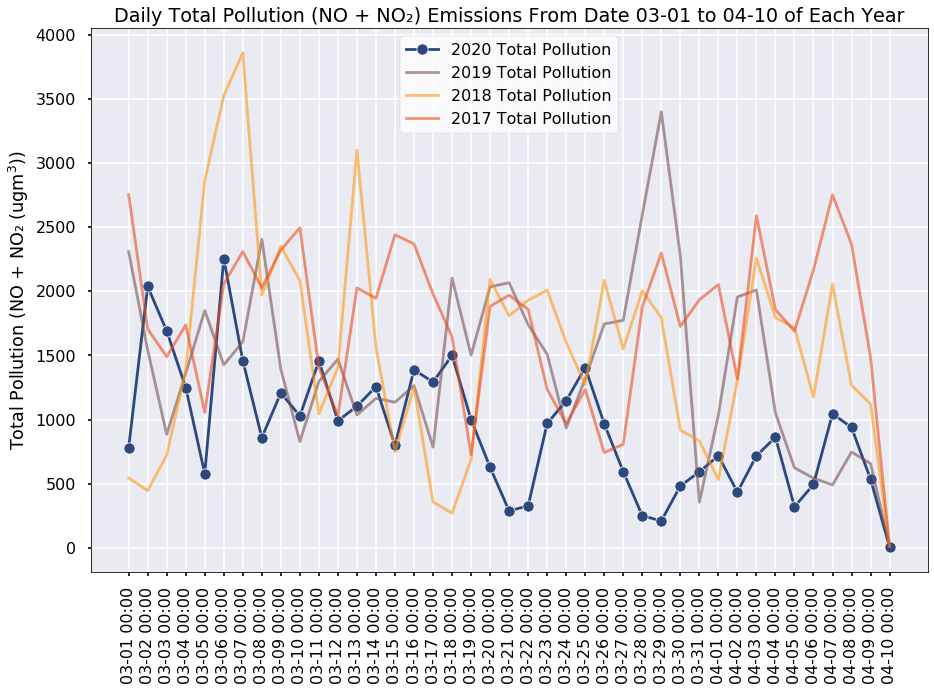

In [44]:
year_comparison(start='03-01',end='04-10',resample_string='D',years_of_data=4) 

## Plot each year by week number

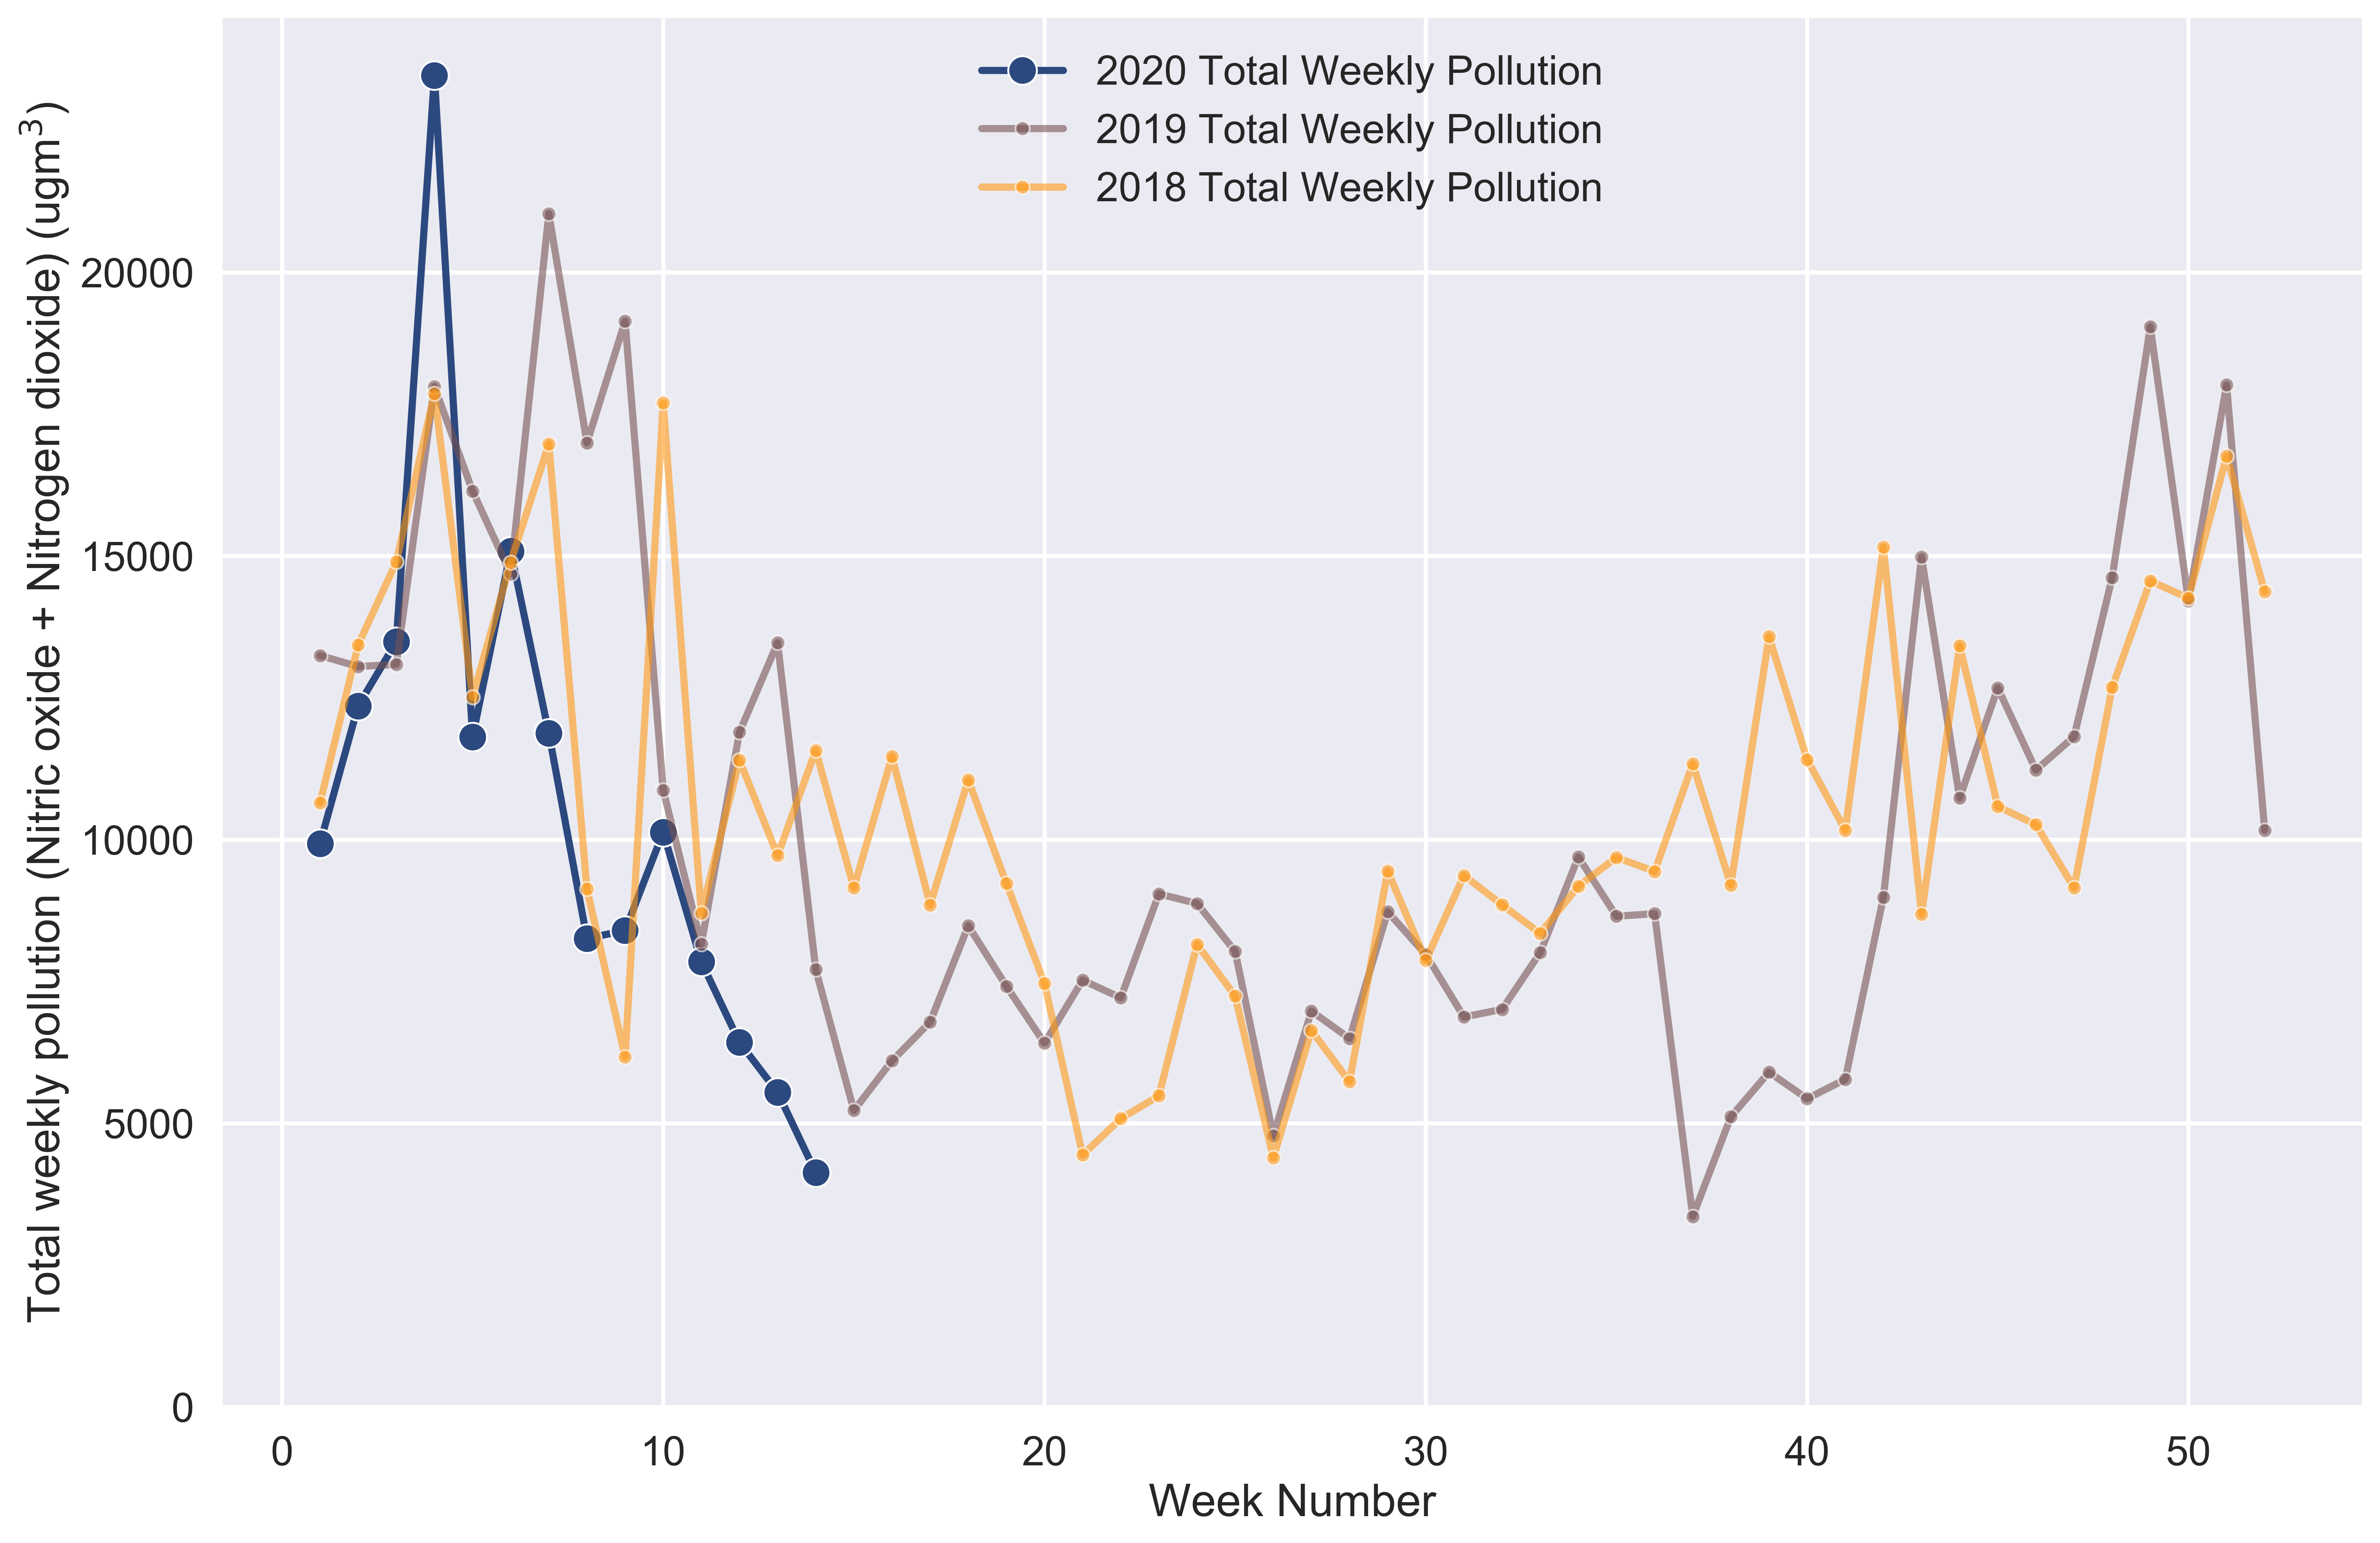

In [93]:
# First, make pivot table
df_all = df_all.loc['2017-01-01':'2020-04-05'] # so it only plots full weeks
weekly = df_all.resample('W').sum()
pivoted = weekly.pivot_table('Total', index=[weekly.index.week], columns=weekly.index.year)
pivoted.columns=['2017','2018','2019','2020']

# plotting data
plt.style.use('seaborn')
plt.style.use('seaborn-poster')


x = plt.figure(figsize=(15,10),dpi=500)
x = sns.lineplot(x=pivoted.index,y=pivoted['2020'],label='2020 Total Weekly Pollution',
             marker='o',alpha=1,color='#2C497F',ci=None)
x = sns.lineplot(x=pivoted.index,y=pivoted['2019'],label='2019 Total Weekly Pollution',
             alpha=0.6,color='#775253',marker='.',ci=None)
x = sns.lineplot(x=pivoted.index,y=pivoted['2018'],label='2018 Total Weekly Pollution',
             alpha=0.6,color='#FF9914',marker='.',ci=None)
#sns.lineplot(x=pivoted.index,y=pivoted['2017'],label='2017 Total Weekly Pollution',
#             alpha=0.6,color='#EC4E20',marker='.',ci=None)

# plot stylings
plt.legend(loc='upper center')
plt.ylabel('Total weekly pollution (Nitric oxide + Nitrogen dioxide) (ugm$^3$)')
plt.xlabel('Week Number')
x.set_ylim(0,None)

plt.savefig('weekly_over_3_years.png')

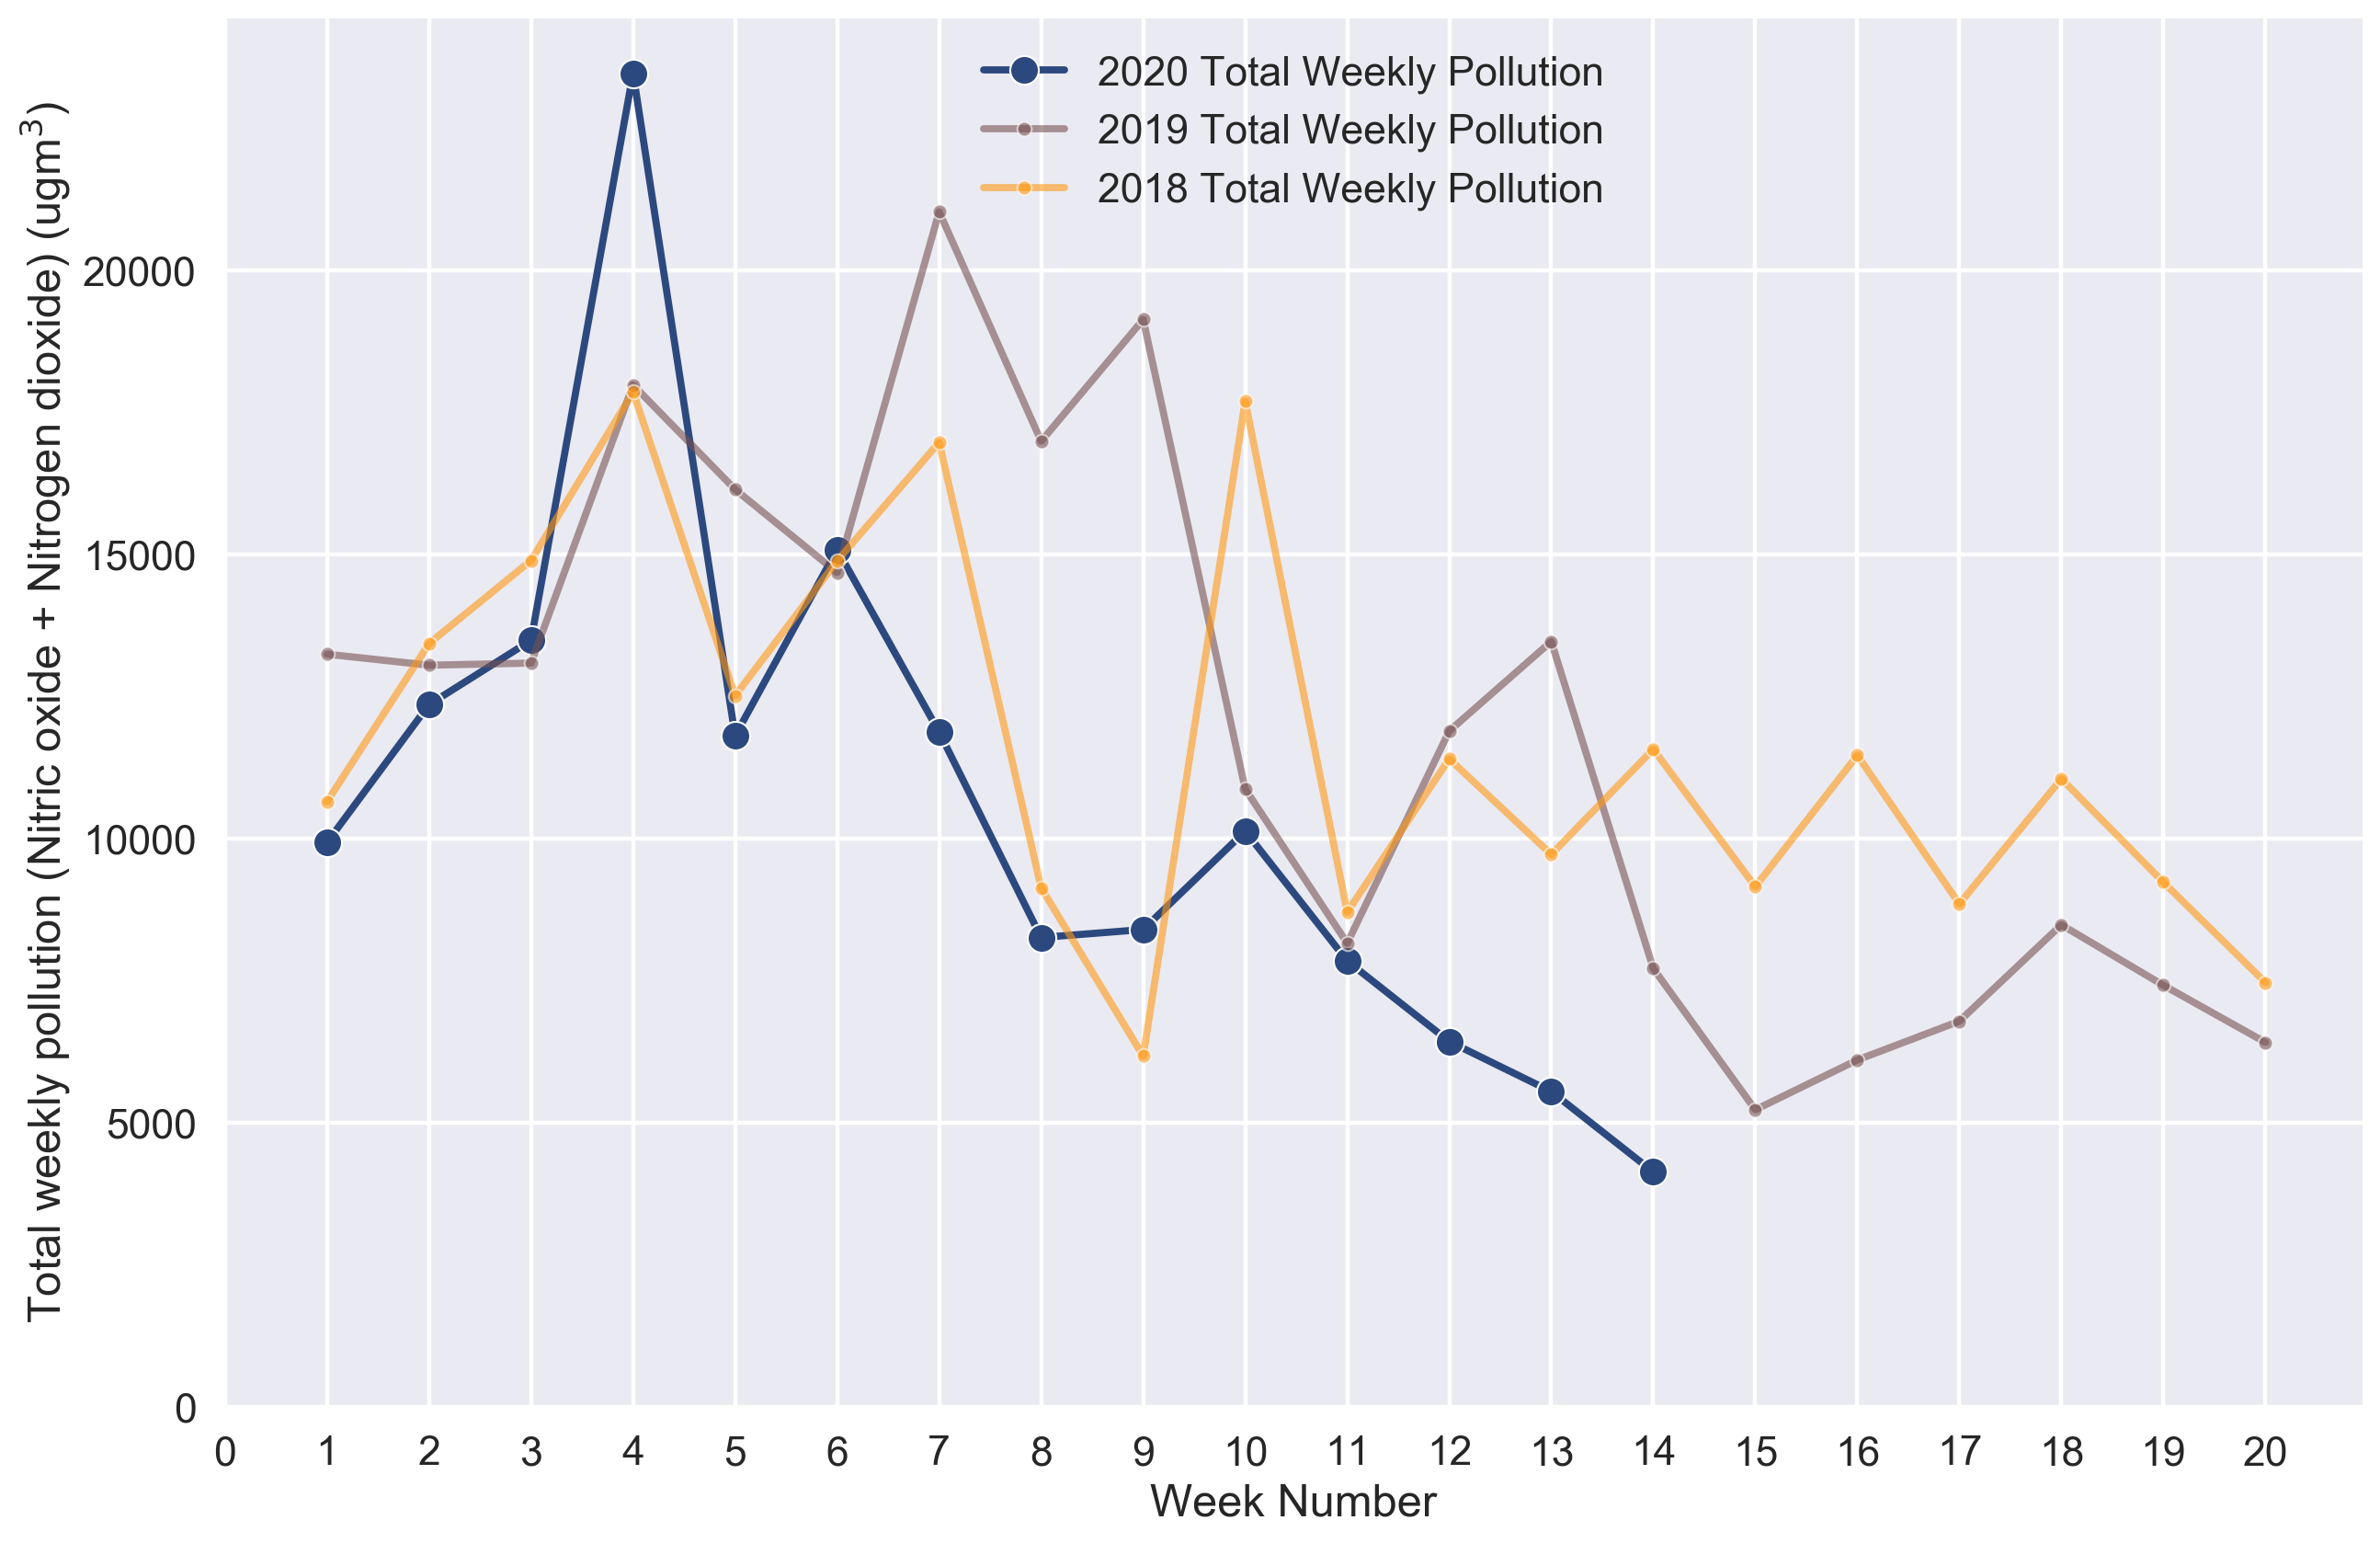

In [30]:
# First, make pivot table
df_all = df_all.loc['2017-01-01':'2020-04-05'] # so it only plots full weeks
weekly = df_all.resample('W').sum()
pivoted = weekly.pivot_table('Total', index=[weekly.index.week], columns=weekly.index.year)
pivoted.columns=['2017','2018','2019','2020']
pivoted = pivoted.iloc[0:20]
# plotting data
x = plt.figure(figsize=(15,10),dpi=200)
x = sns.lineplot(x=pivoted.index,y=pivoted['2020'],label='2020 Total Weekly Pollution',
             marker='o',alpha=1,color='#2C497F',ci=None)
x = sns.lineplot(x=pivoted.index,y=pivoted['2019'],label='2019 Total Weekly Pollution',
             alpha=0.6,color='#775253',marker='.',ci=None)
x = sns.lineplot(x=pivoted.index,y=pivoted['2018'],label='2018 Total Weekly Pollution',
             alpha=0.6,color='#FF9914',marker='.',ci=None)
#sns.lineplot(x=pivoted.index,y=pivoted['2017'],label='2017 Total Weekly Pollution',
#             alpha=0.6,color='#EC4E20',marker='.',ci=None)

# plot stylings
plt.style.use('seaborn-poster')
plt.legend(loc='upper center')
plt.ylabel('Total weekly pollution (Nitric oxide + Nitrogen dioxide) (ugm$^3$)')
plt.xlabel('Week Number')
x.set_ylim(0,None)
plt.xticks(np.arange(21),np.arange(21))
plt.savefig('weekly_over_3_years_limited.png')

# Weekly Pivot

In [45]:
# Make pivot table with specific date range so I'm only looking at full weeks
df_all_ = df_all.loc['2017-01-01':'2020-04-05'] 
weekly = df_all_.resample('W').sum()
pivoted = weekly.pivot_table('Total', index=[weekly.index.week], columns=weekly.index.year)
pivoted.columns=['2017','2018','2019','2020']

# new columns
pivoted['% of 2019'] = (pivoted['2020']/pivoted['2019'])*100
pivoted['% change'] = (pivoted['2020']/pivoted['2019']-1)*100

#median of previous years
z = pivoted.loc[:,['2017','2018','2019']].median(axis=1)
pivoted['Median Over Previous Years'] = z

# median calculation columns
pivoted['% Of Median'] = (pivoted['2020']/pivoted['Median Over Previous Years'])*100
pivoted['% Change From Median'] = ((pivoted['2020']/pivoted['Median Over Previous Years'])-1)*100

# neater dataframe
pivoted_clean = pivoted.iloc[:,[6,3,7,8]]
pivoted_clean.head(20)

,Median Over Previous Years,2020,% Of Median,% Change From Median
Date Time,,,,
1,10648.36125,9933.16364,93.283496,-6.716504
2,13051.44925,12357.81916,94.685417,-5.314583
3,13088.40537,13489.29181,103.062913,3.062913
4,17983.94996,23472.47084,130.518996,30.518996
5,12513.92041,11808.34109,94.361644,-5.638356
6,14681.96571,15088.20791,102.766947,2.766947
7,16973.35724,11875.23210,69.963955,-30.036045
8,11388.30904,8258.59008,72.518142,-27.481858
9,13554.37781,8399.01153,61.965305,-38.034695


Text(0.5, 1, 'Total Pollution Measured Per Week Of Each Year')

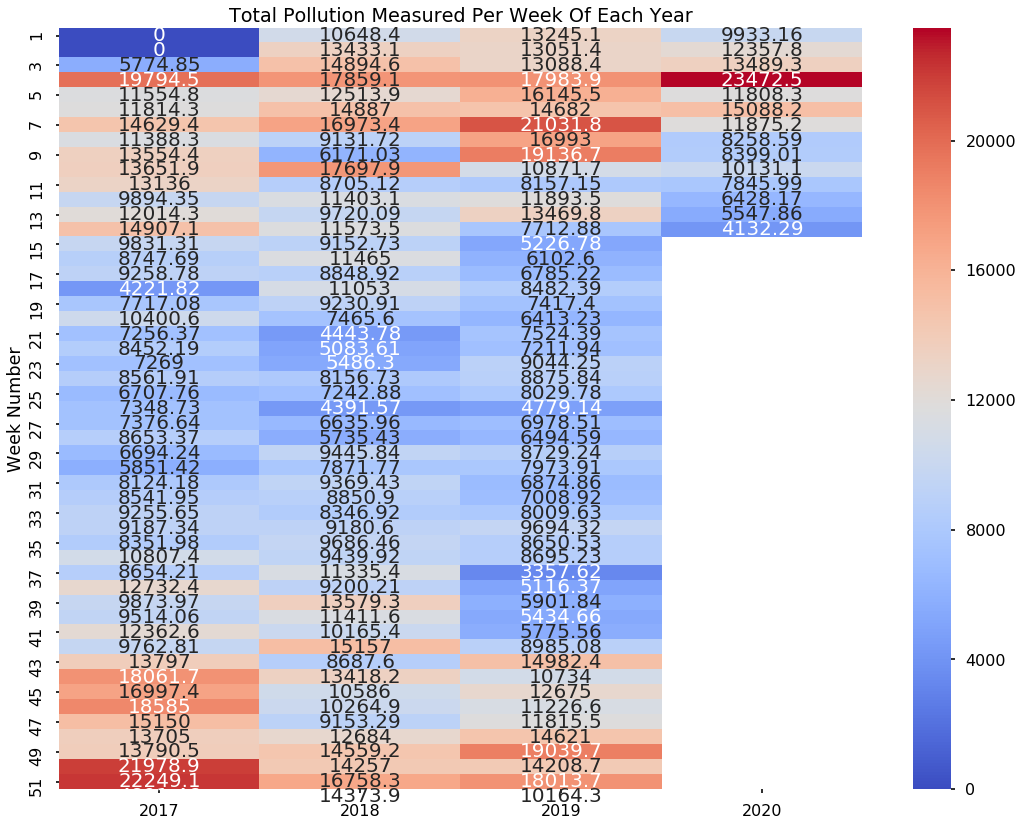

In [46]:
ax = sns.heatmap(pivoted[['2017','2018','2019','2020']],cmap='coolwarm',annot=True,fmt='g',annot_kws={"size": 20})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ylabel('Week Number')
title('Total Pollution Measured Per Week Of Each Year')

Text(0.5, 1, '2020 Weekly Pollution Compared To Median Pollution of Previous 3 Years')

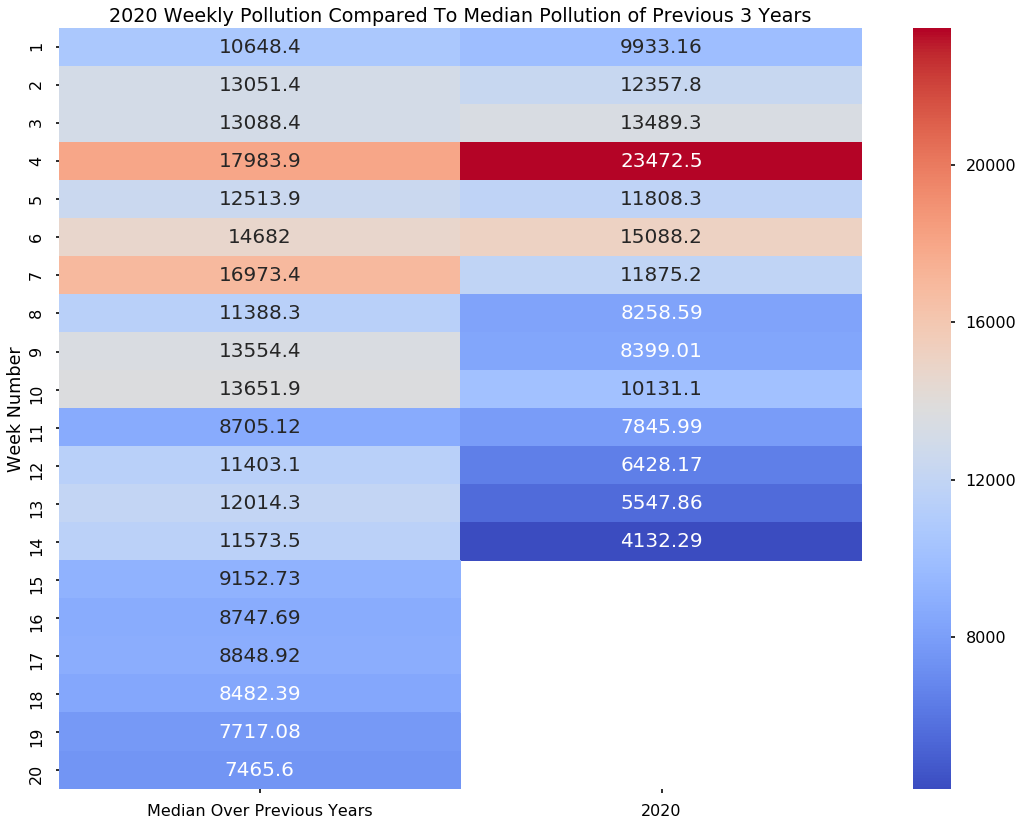

In [47]:
pivoted_clean_ = pivoted_clean.iloc[:20,:]

ax = sns.heatmap(pivoted_clean_[['Median Over Previous Years','2020']],cmap='coolwarm',annot=True,fmt='g',annot_kws={"size": 20})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ylabel('Week Number')
title('2020 Weekly Pollution Compared To Median Pollution of Previous 3 Years')
#xticks(np.arange(2),['Median Total Pollution Of 2017, 2018 and 2019','2020 Weekly Total Pollution'])

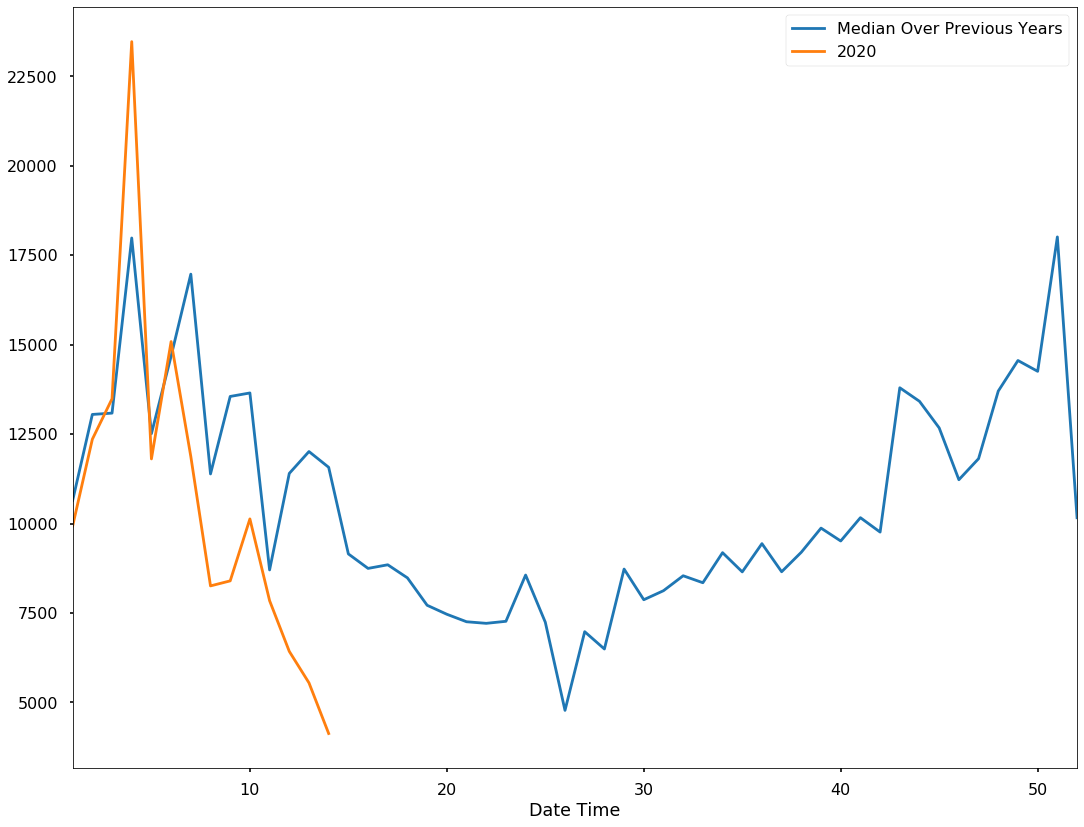

In [57]:
pivoted_clean[['Median Over Previous Years','2020']].plot()

# Monthly Pivot

In [48]:
# Monthly pivot table with specific date range so only full months are measured
df_all_ = df_all.loc['2017-01-01':'2020-03-31'] 
monthly = df_all_.resample('M').sum()
month_piv = monthly.pivot_table('Total', index=[monthly.index.month], columns=monthly.index.year)
month_piv.columns=['2017','2018','2019','2020']

# new columns
month_piv['% of 2019'] = (month_piv['2020']/month_piv['2019'])*100
month_piv['% change'] = ((month_piv['2020']/month_piv['2019'])-1)*100

# median of previous years
z = month_piv.loc[:,['2017','2018','2019']].median(axis=1)
month_piv['Median Of Previous Years'] = z

# median columns 
month_piv['% Of Median'] = (month_piv['2020']/month_piv['Median Of Previous Years'])*100
month_piv['% Change From Median'] = ((month_piv['2020']/month_piv['Median Of Previous Years'])-1)*100

# cleaned up dataframe 
month_piv_clean = month_piv.iloc[:,[6,3,7,8]]
month_piv_clean

,Median Of Previous Years,2020,% Of Median,% Change From Median
Date Time,,,,
1,63018.95106,65301.76898,103.622431,3.622431
2,51400.74592,45423.20749,88.370717,-11.629283
3,50098.27769,31812.27883,63.499745,-36.500255
4,42509.04851,NaN,NaN,NaN
5,32834.78904,NaN,NaN,NaN
6,32496.47416,NaN,NaN,NaN
7,32978.27321,NaN,NaN,NaN
8,38861.70214,NaN,NaN,NaN
9,44477.42794,NaN,NaN,NaN


Text(0.5, 1, 'Total Pollution Measured Per Month Of Each Year')

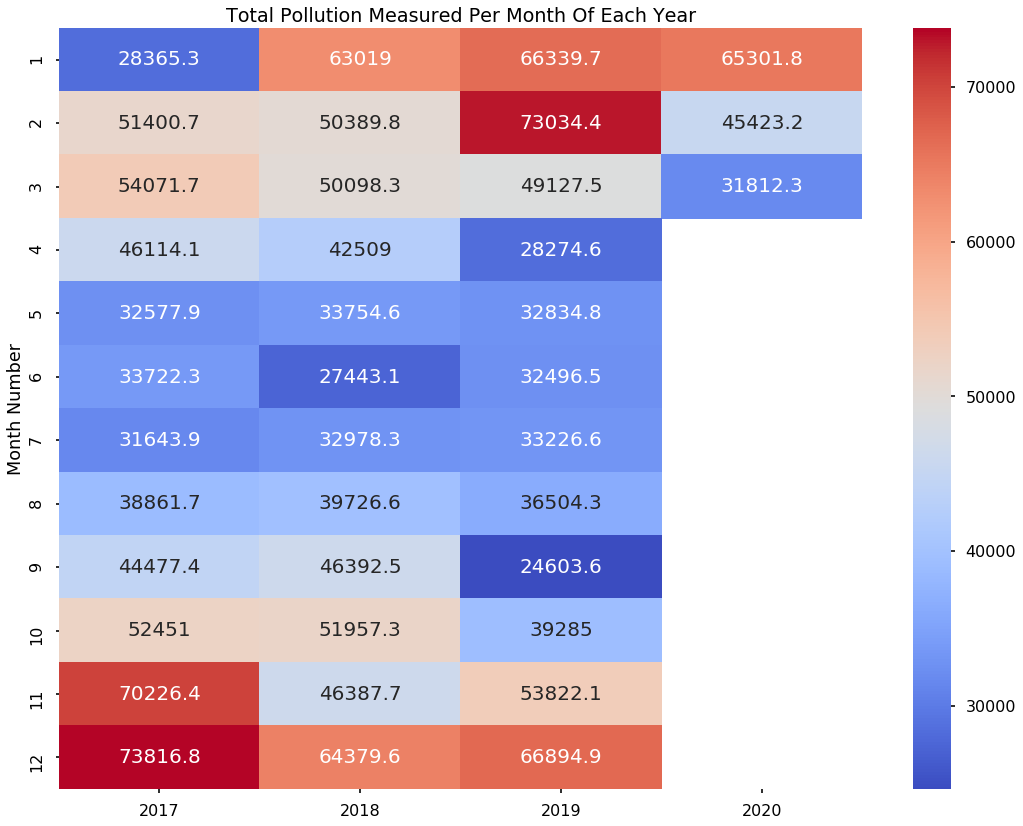

In [49]:
ax = sns.heatmap(month_piv[['2017','2018','2019','2020']],cmap='coolwarm',annot=True,fmt='g',annot_kws={"size": 20})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ylabel('Month Number')
title('Total Pollution Measured Per Month Of Each Year')

Text(0.5, 1, '2020 Monthly Pollution Compared To Median Pollution of Previous 3 Years')

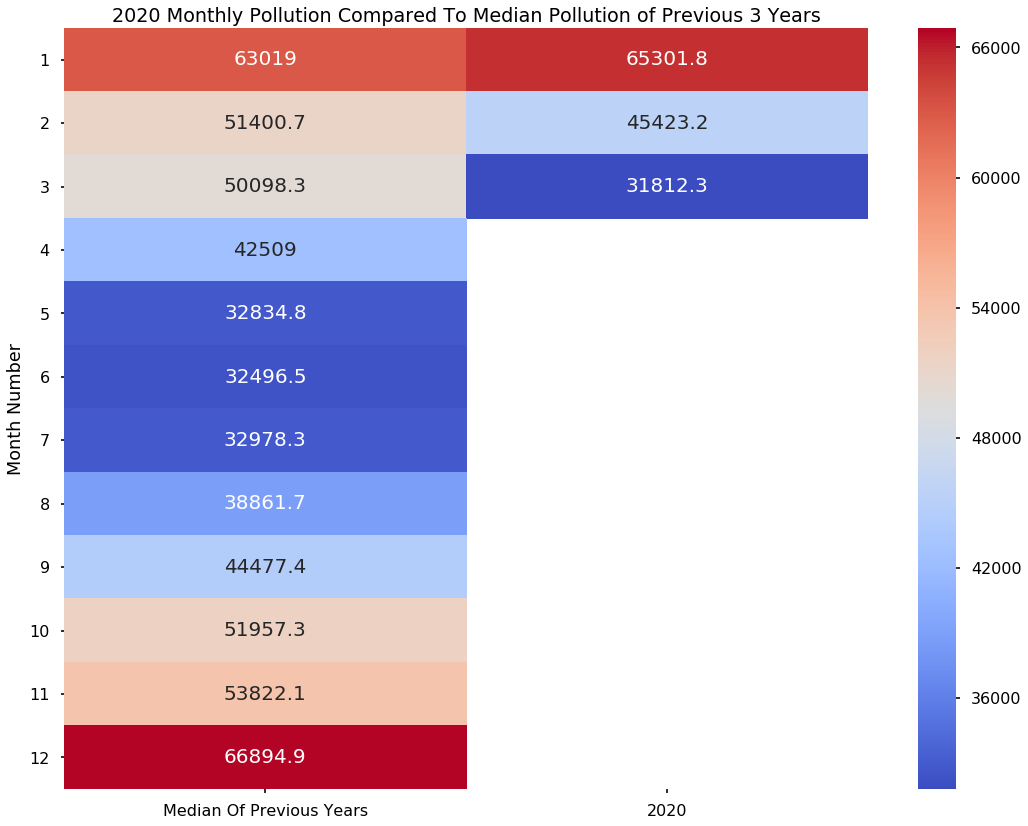

In [50]:
ax = sns.heatmap(month_piv_clean[['Median Of Previous Years','2020']],cmap='coolwarm',annot=True,fmt='g',annot_kws={"size": 20})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ylabel('Month Number')
#yticks(np.arange(12),['Jan','Feb','Mar','Apr','Jun','July','Aug','Sep','Oct','Nov','Dec'])
yticks(rotation=0)
title('2020 Monthly Pollution Compared To Median Pollution of Previous 3 Years')

# Making graphs of above (instead of heatmaps)

# Total Emissions for 1 month of each year


In [13]:
def month_comparison(month_str,years_to_plot):
    '''
    month_str = month in two digit format i.e. March = 03
    years_to_plot = integer. If 4, plot all 4 years, if 3 plot most recent 3 years etc
    '''
    months_with_28_days=['2','02']
    months_with_31_days=['1','01','3','03','5','05','7','07','8','08','10','12']
    months_with_30_days=['4','04','6','06','9','09','11']
    
    if month_str in(months_with_28_days):
        days_in_month = 28
    elif month_str in(months_with_31_days):
        days_in_month = 31
    elif month_str in(months_with_30_days):
        days_in_month=30
        
    # getting month name for title of plot
    monthinteger = int(month_str)
    month = calendar.month_name[monthinteger]
    
    month_17 = df_all.loc['2017-{}-01'.format(month_str):'2017-{}-{}'.format(month_str,days_in_month)] 
    month_18 = df_all.loc['2018-{}-01'.format(month_str):'2018-{}-{}'.format(month_str,days_in_month)]
    month_19 = df_all.loc['2019-{}-01'.format(month_str):'2019-{}-{}'.format(month_str,days_in_month)]
    month_20 = df_all.loc['2020-{}-01'.format(month_str):'2020-{}-{}'.format(month_str,days_in_month)]

    month_17_no = month_17['Nitric oxide'].sum()
    month_17_nd = month_17['Nitrogen dioxide'].sum()

    month_18_no = month_18['Nitric oxide'].sum()
    month_18_nd = month_18['Nitrogen dioxide'].sum()

    month_19_no = month_19['Nitric oxide'].sum()
    month_19_nd = month_19['Nitrogen dioxide'].sum()

    month_20_no = month_20['Nitric oxide'].sum()
    month_20_nd = month_20['Nitrogen dioxide'].sum()

    # Making a new dataframe to plot
    data = {'{}-2017'.format(month_str):[month_17_no,month_17_nd],
           '{}-2018'.format(month_str):[month_18_no, month_18_nd],
            '{}-2019'.format(month_str):[month_19_no, month_19_nd],
            '{}-2020'.format(month_str):[month_20_no, month_20_nd]}

    df = pd.DataFrame(data)
    df.index = ['Nitric Oxide','Nitrogen Dioxide']
    
    
    if years_to_plot==4:
        df_=df
    elif years_to_plot==3:
        df_=df[['{}-2018'.format(month_str),'{}-2019'.format(month_str),'{}-2020'.format(month_str)]]
    elif years_to_plot==2:
        df_=df[['{}-2019'.format(month_str),'{}-2020'.format(month_str)]]
    elif years_to_plot==1:
        df_=df[['{}-2020'.format(month_str)]]
    
    #plt.style.use('seaborn-poster')
    plt.style.use('tableau-colorblind10')
    df_.plot.bar(figsize=[15,10])
    plt.title('Total Emissions In {} of Each Year'.format(month))

    plt.ylabel('Total Emissions Measured (ugm$^3$)')
    plt.xticks(rotation=0)
    plt.legend(loc='upper left')

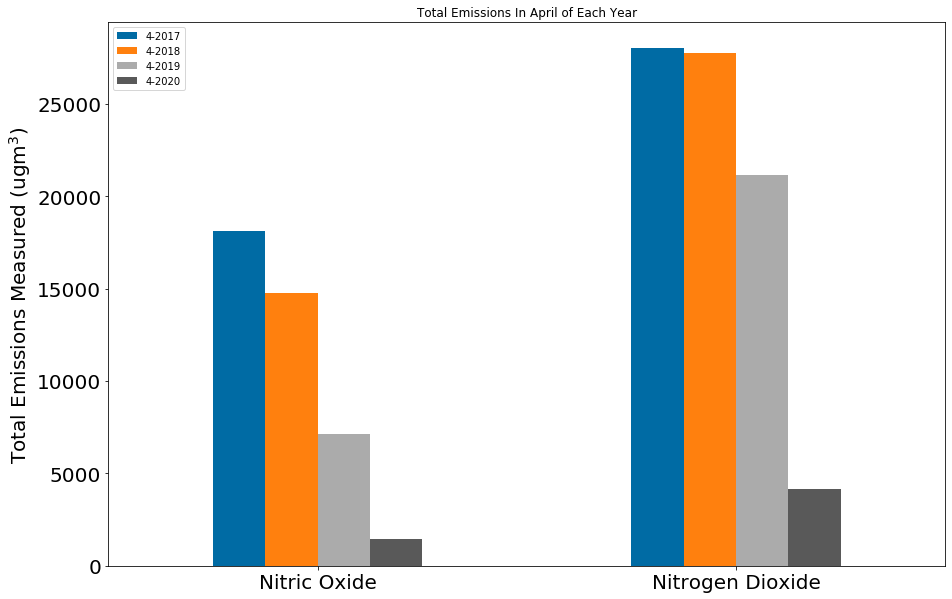

In [14]:
month_comparison(month_str='4',years_to_plot=4)

# add specifying the years to analyse too 

# Looking at different features like weekday, weather etc
- Currently have week, day of week, quarter, weekday or weekend

In [137]:
df_all

,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide,Date Time,Week,Day Of Week,Quarter,Weekday Or Weekend,Total
Date Time,,,,,,,,,
2017-01-01 01:00:00,NaN,NaN,NaN,2017-01-01 01:00:00,52,6,1,Weekend,NaN
2017-01-01 02:00:00,NaN,NaN,NaN,2017-01-01 02:00:00,52,6,1,Weekend,NaN
2017-01-01 03:00:00,NaN,NaN,NaN,2017-01-01 03:00:00,52,6,1,Weekend,NaN
2017-01-01 04:00:00,NaN,NaN,NaN,2017-01-01 04:00:00,52,6,1,Weekend,NaN
2017-01-01 05:00:00,NaN,NaN,NaN,2017-01-01 05:00:00,52,6,1,Weekend,NaN
...,...,...,...,...,...,...,...,...,...
2020-04-03 20:00:00,5.86231,28.68750,37.67625,2020-04-03 20:00:00,14,4,2,Weekday,34.54981
2020-04-03 21:00:00,3.36771,27.92250,33.08625,2020-04-03 21:00:00,14,4,2,Weekday,31.29021
2020-04-03 22:00:00,4.98920,22.37625,30.02625,2020-04-03 22:00:00,14,4,2,Weekday,27.36545


Text(0.5, 0, '')

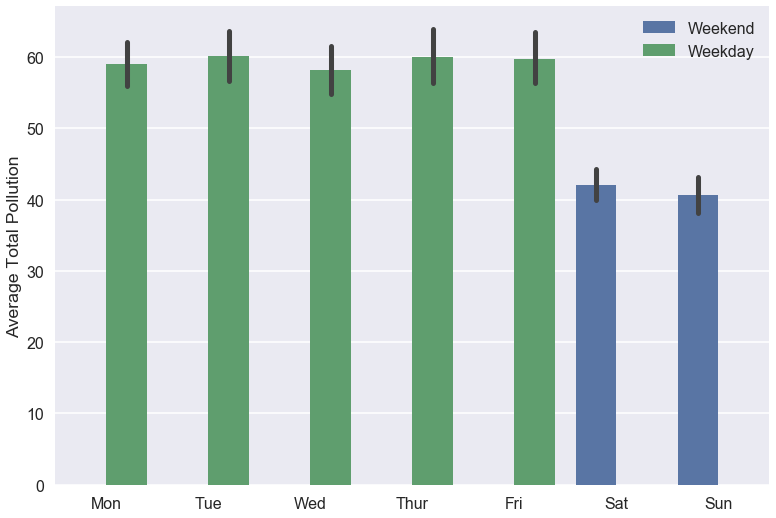

In [152]:
sns.barplot(x='Day Of Week',y='Total',data=df_2017,hue = 'Weekday Or Weekend')
plt.xticks(np.arange(7),['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
plt.legend(title=None)
plt.ylabel('Average Total Pollution')
## What are the units for this? Also I don't even know if it is doing an average
plt.xlabel('')

No handles with labels found to put in legend.


Text(0.5, 0, 'Quarter')

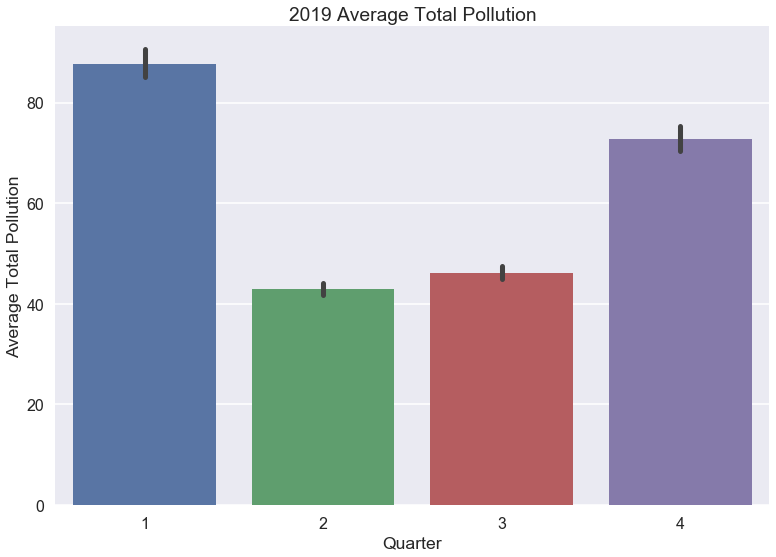

In [164]:
# how is this grouping them? Is it doing an average of hourly data?

sns.barplot(x='Quarter',y='Total',data=df_2019)
plt.legend(title=None)
plt.ylabel('Average Total Pollution')
plt.title('2019 Average Total Pollution')
## What are the units for this? Also I don't even know if it is doing an average
plt.xlabel('Quarter')

# Plotting months of all years next to each other 

<Figure size 18000x18000 with 0 Axes>

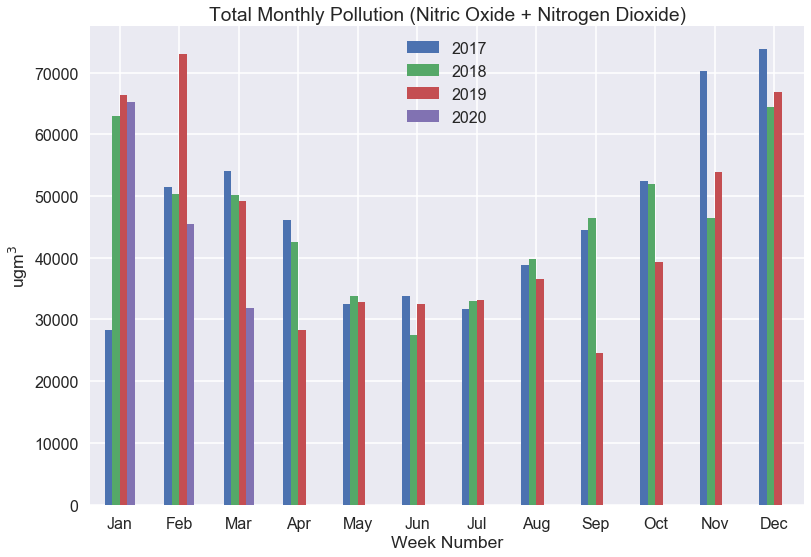

In [12]:
x = df_all.loc['2017-01-01':'2020-03-31'] # so it's only full months
# First, make pivot table
monthly = x.resample('M').sum()
pivoted = monthly.pivot_table('Total', index=[monthly.index.month], columns=monthly.index.year)
pivoted.columns=['2017','2018','2019','2020']

# plotting data
plt.style.use('seaborn')
plt.style.use('seaborn-poster')
plt.figure(figsize=(15,15),dpi=1200)
pivoted.plot(kind='bar')

# plot stylings
plt.title('Total Monthly Pollution (Nitric Oxide + Nitrogen Dioxide)')
plt.legend(loc='upper center')
plt.ylabel('ugm$^3$')
plt.xlabel('Week Number')
plt.xticks(rotation=0)
plt.xticks(np.arange(12),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.savefig('Monthly Pollution.png')

# Following Udemy course

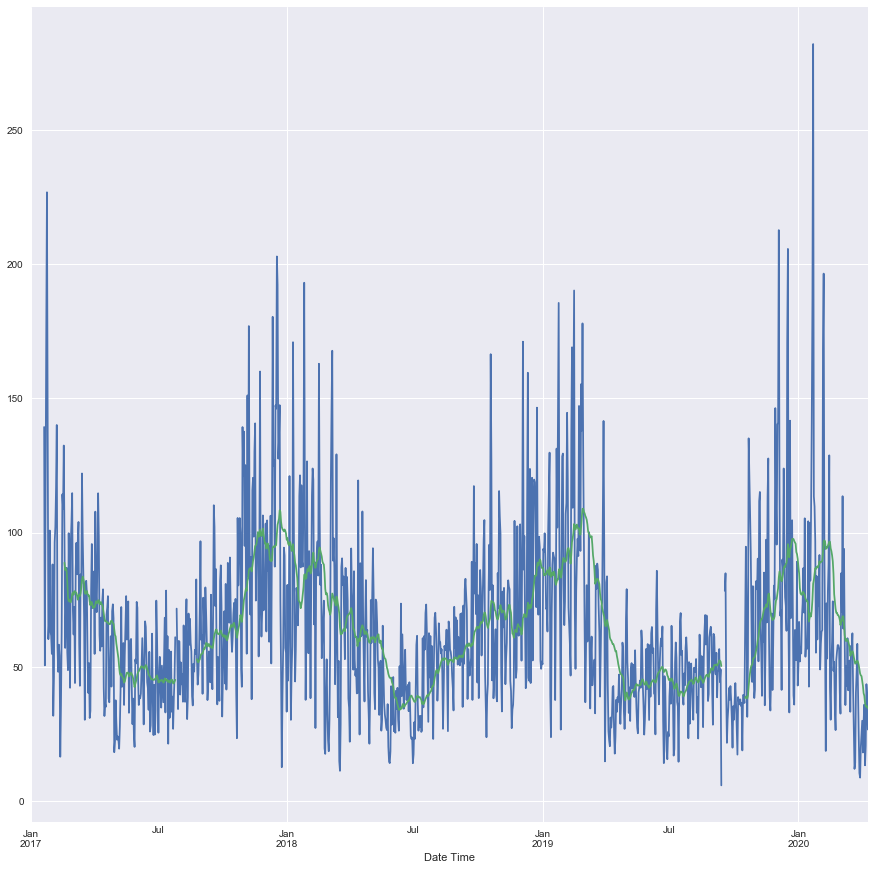

In [42]:
df_all['Total'].resample('D').mean().plot(figsize=[15,15])
daily = df_all.resample('D').mean()
daily.rolling(window=30).mean()['Total'].plot()

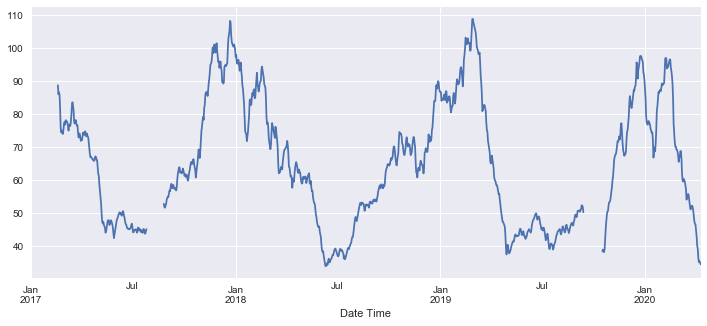

In [41]:
#df_all['Total'].resample('D').mean().plot(figsize=[12,5])
daily = df_all.resample('D').mean()
daily.rolling(window=30).mean()['Total'].plot(figsize=[12,5])